## Visualize Results: Maps

In [1]:
# import libraries
from cartopy import crs as ccrs, feature as cfeature
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap, TwoSlopeNorm, Normalize
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as mticker
from matplotlib.ticker import StrMethodFormatter
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import xarray as xr
import os
import numpy as np

Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
# load country borders
countries_path = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
countries = gpd.read_file(countries_path)

# get german border
ger_border = countries[countries['NAME'] == 'Germany'].to_crs(epsg = 32632)

# load state borders
states_path = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
states = gpd.read_file(states_path)

# get german federal states
ger_states = states[states['admin'] == 'Germany'].to_crs(epsg = 32632)

c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\pyogrio\core.py:36: RuntimeWarning: Could not detect PROJ data files.  Set PROJ_LIB environment variable to the correct path.
  _init_proj_data()


### NDVI Trend

In [4]:
ndvi_BL = xr.open_dataset("./Spatial_Trends/NDVI_Spatial_Trend_BL.nc")
ndvi_NL = xr.open_dataset("./Spatial_Trends/NDVI_Spatial_Trend_NL.nc")

c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\rasterio\env.py:664: RuntimeWarning: Cannot find gdalvrt.xsd (GDAL_DATA is not defined)
  elif GDALDataFinder().find_file("gdalvrt.xsd"):


In [31]:
BL_vals = ndvi_BL.variables['NDVI'][:,:].values
NL_vals = ndvi_NL.variables['NDVI'][:,:].values

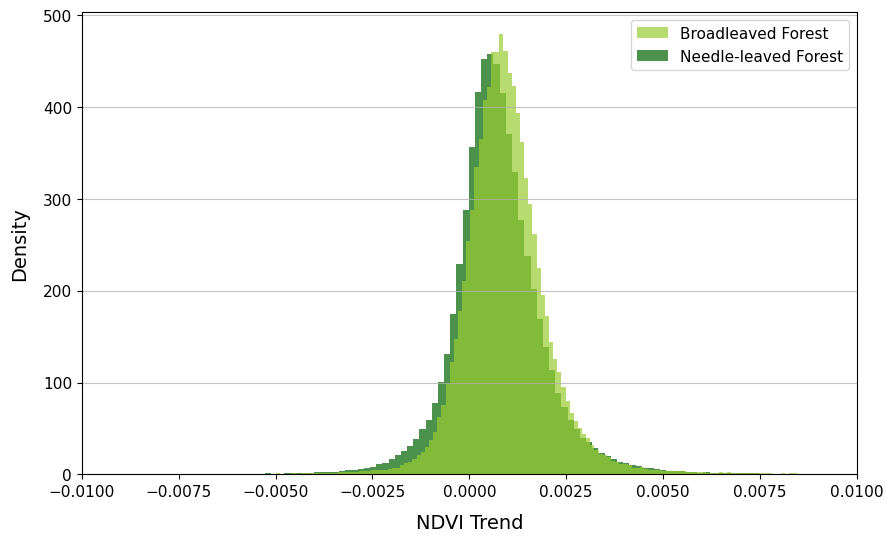

In [ ]:
# plot histograms to look at distribution of values
plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('NDVI Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.01, 0.01) 

plt.savefig("./Figures/NDVI_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [32]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc}")
print(f"Calculated 75th Percentile: {vmax_perc}")

Calculated 25th Percentile: 0.00016027774595387873
Calculated 75th Percentile: 0.0013916594156364551


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\2060684699.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


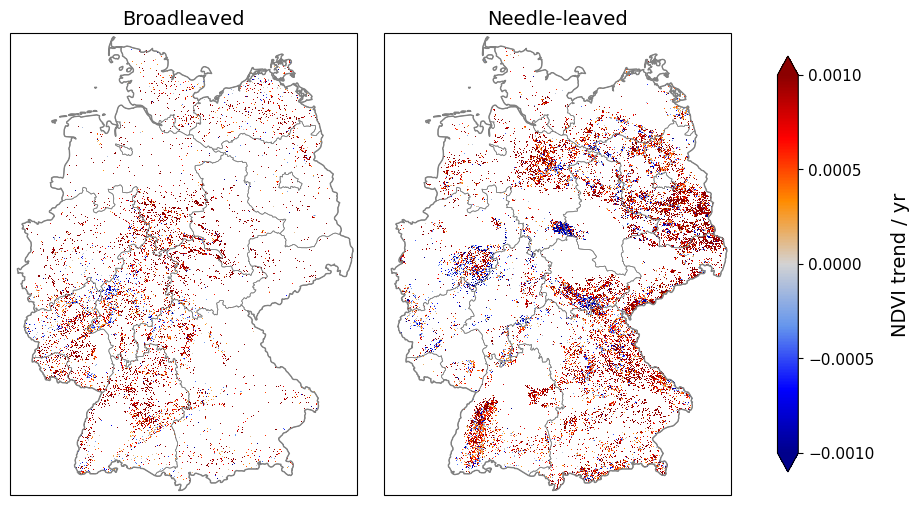

In [23]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = ndvi_BL.variables['NDVI'][:,:]
NL = ndvi_NL.variables['NDVI'][:,:]
lats = ndvi_BL.variables['lat'][:]
lons = ndvi_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.001
vmax = 0.001

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("NDVI trend / yr", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/NDVI_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### LAI Trend

In [25]:
lai_BL = xr.open_dataset("./Spatial_Trends/LAI_Spatial_Trend_BL.nc")
lai_NL = xr.open_dataset("./Spatial_Trends/LAI_Spatial_Trend_NL.nc")

In [28]:
BL_vals = lai_BL.variables['LAI'][:,:].values
NL_vals = lai_NL.variables['LAI'][:,:].values

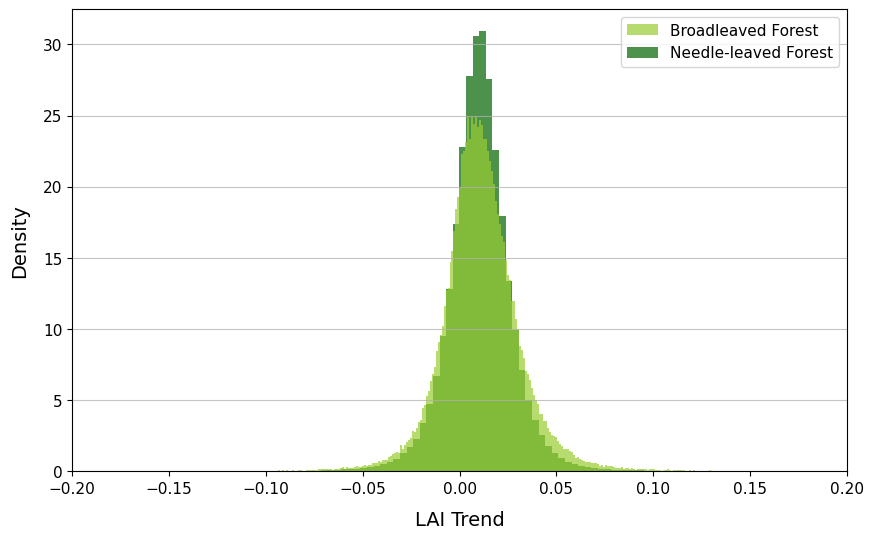

In [ ]:
# plot histograms to look at distribution of values
plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=50000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=50000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('LAI Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.2, 0.2) 

plt.savefig("./Figures/LAI_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [29]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc}")
print(f"Calculated 75th Percentile: {vmax_perc}")

Calculated 25th Percentile: 0.0008442768119391577
Calculated 75th Percentile: 0.020087476528599657


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\3078379782.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


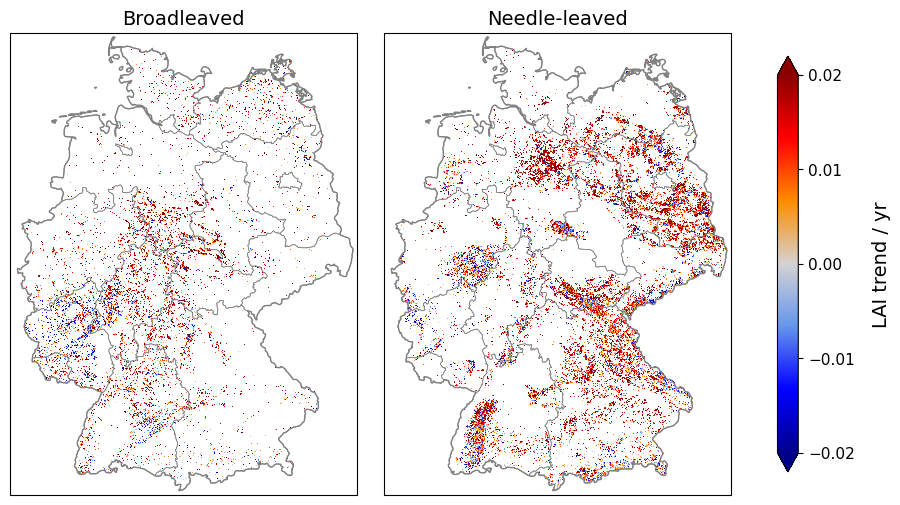

In [26]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = lai_BL.variables['LAI'][:,:]
NL = lai_NL.variables['LAI'][:,:]
lats = lai_BL.variables['lat'][:]
lons = lai_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.02
vmax = 0.02

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 
cbar.set_label("LAI trend / yr", fontsize = 14, labelpad = 12)

plt.tight_layout()
plt.savefig("./Figures/LAI_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### FAPAR Trend

In [27]:
fapar_BL = xr.open_dataset("./Spatial_Trends/FAPAR_Spatial_Trend_BL.nc")
fapar_NL = xr.open_dataset("./Spatial_Trends/FAPAR_Spatial_Trend_NL.nc")

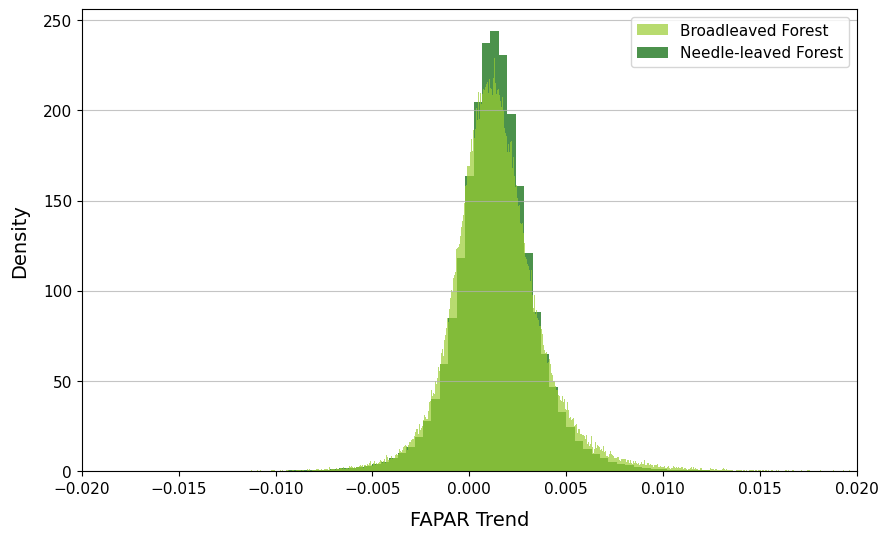

In [17]:
# plot histograms to look at distribution of values

BL_vals = fapar_BL.variables['FAPAR'][:,:].values
NL_vals = fapar_NL.variables['FAPAR'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('FAPAR Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.02, 0.02) 

plt.savefig("./Figures/FAPAR_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [25]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc}")
print(f"Calculated 75th Percentile: {vmax_perc}")

Calculated 25th Percentile: 0.000167695615993687
Calculated 75th Percentile: 0.002530756518404726


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\1533954902.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


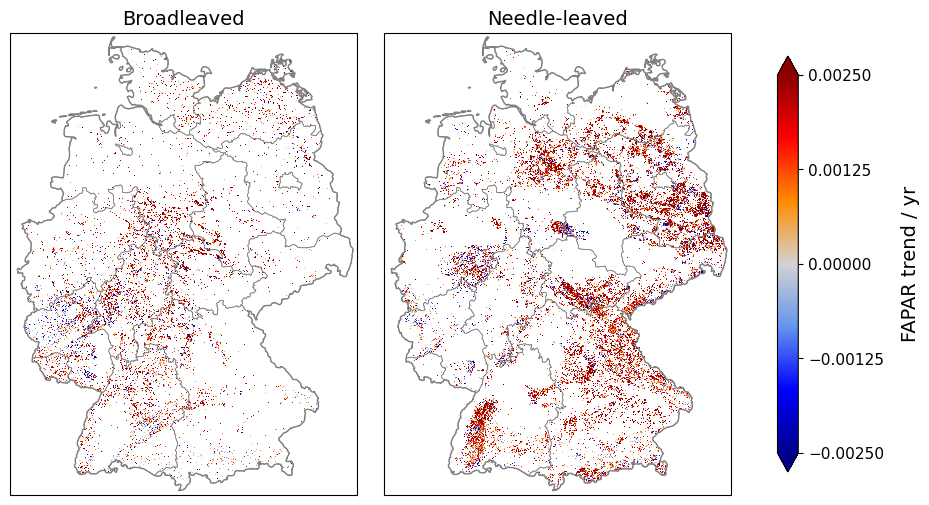

In [29]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = fapar_BL.variables['FAPAR'][:,:]
NL = fapar_NL.variables['FAPAR'][:,:]
lats = fapar_BL.variables['lat'][:]
lons = fapar_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0025
vmax = 0.0025

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 
cbar.set_label("FAPAR trend / yr", fontsize = 14, labelpad = 12)

plt.tight_layout()
plt.savefig("./Figures/FAPAR_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### Air Temperature Trend

In [7]:
t2m_BL = xr.open_dataset("./Spatial_Trends/t2m_Spatial_Trend_BL.nc")
t2m_NL = xr.open_dataset("./Spatial_Trends/t2m_Spatial_Trend_NL.nc")

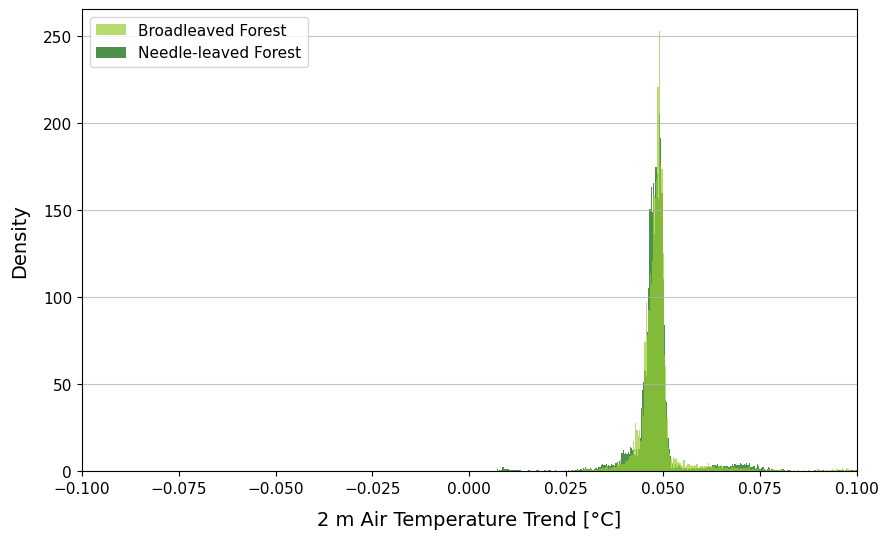

In [35]:
# plot histograms to look at distribution of values

BL_vals = t2m_BL.variables['t2m'][:,:].values
NL_vals = t2m_NL.variables['t2m'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('2 m Air Temperature Trend [°C]', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc="upper left", fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.1, 0.1) 

plt.savefig("./Figures/Temperature_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [36]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc}")
print(f"Calculated 75th Percentile: {vmax_perc}")

Calculated 25th Percentile: 0.04655779558978811
Calculated 75th Percentile: 0.049552406501904116


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\520490334.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


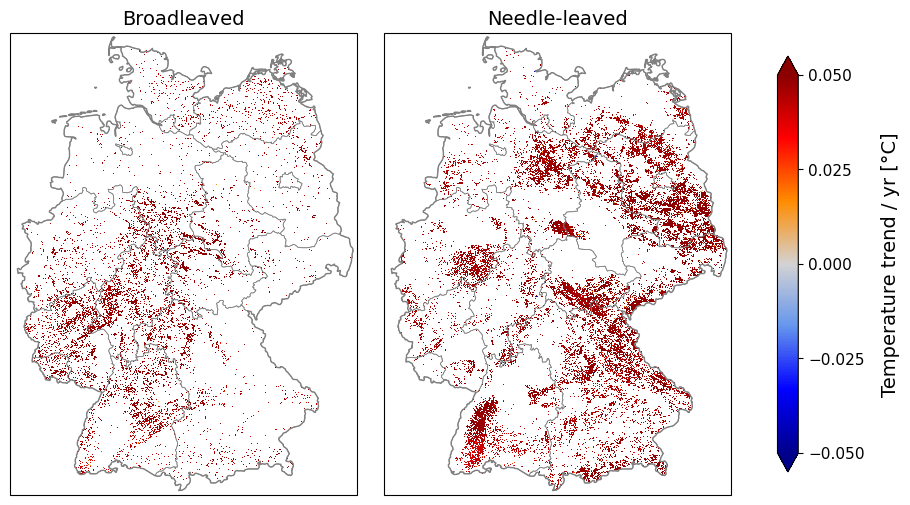

In [30]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = t2m_BL.variables['t2m'][:,:]
NL = t2m_NL.variables['t2m'][:,:]
lats = t2m_BL.variables['lat'][:]
lons = t2m_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.05
vmax = 0.05

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Temperature trend / yr [°C]", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Temperature_Spatial_Trend_newcm.png", bbox_inches="tight", dpi = 300)
plt.show()

### Precipitation Trend Germany

In [31]:
tp = xr.open_dataset("./Spatial_Trends/tp_Spatial_Trend_GER.nc")

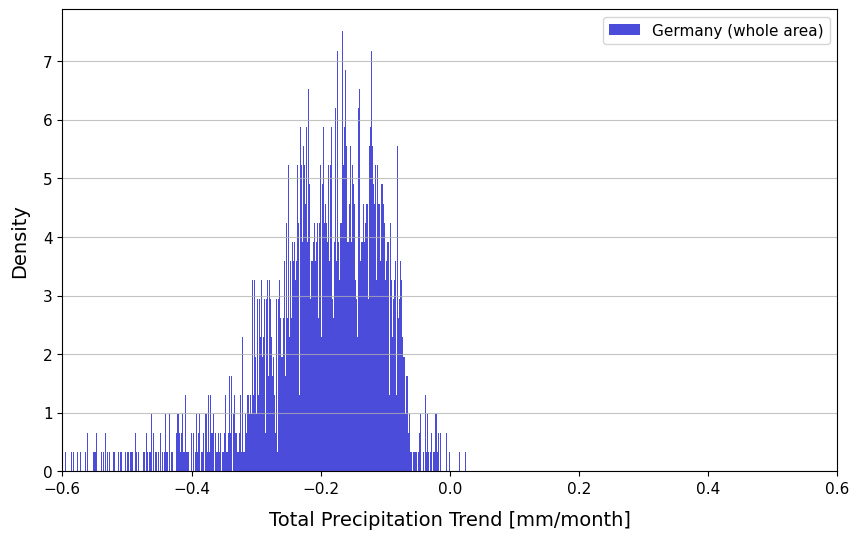

In [39]:
# plot histogram to look at distribution of values

tp_vals = tp.variables['tp'][:,:].values

plt.figure(figsize=(10, 6))

plt.hist(tp_vals.flatten(), bins=1000, alpha=0.7, label='Germany (whole area)', color='mediumblue', density=True) 

# add labels
plt.xlabel('Total Precipitation Trend [mm/month]', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

plt.legend(loc = 1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.6, 0.6) 

plt.savefig("./Figures/Precipitation_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [40]:
# have a look at the percentiles
data = tp_vals.flatten()

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(data[~np.isnan(data)], lower_percentile)
vmax_perc = np.percentile(data[~np.isnan(data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc}")
print(f"Calculated 75th Percentile: {vmax_perc}")

Calculated 25th Percentile: -0.24590905295489623
Calculated 75th Percentile: -0.12993223171805487


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\1379092244.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


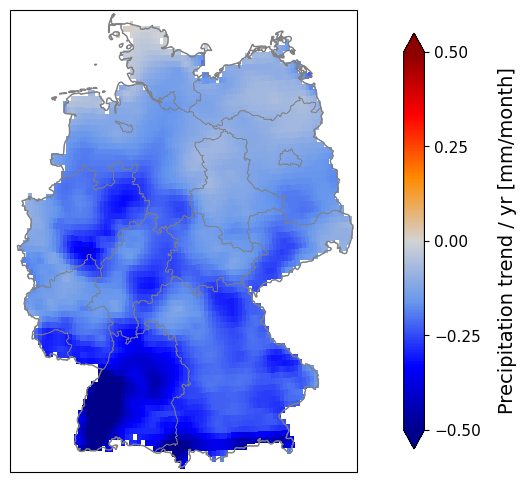

In [32]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variable from xarray
tp_var = tp.variables['tp'][:,:]
lats = tp.variables['lat'][:]
lons = tp.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.5
vmax = 0.5

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})

ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

# plot data
im = ax.pcolormesh(
        lons, lats, tp_var,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto")

# plot borders
ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

# add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Precipitation trend / yr [mm/month]", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Precipitation_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### Wind Speed Trend

In [12]:
wind10m_BL = xr.open_dataset("./Spatial_Trends/wind10m_Spatial_Trend_BL.nc")
wind10m_NL = xr.open_dataset("./Spatial_Trends/wind10m_Spatial_Trend_NL.nc")

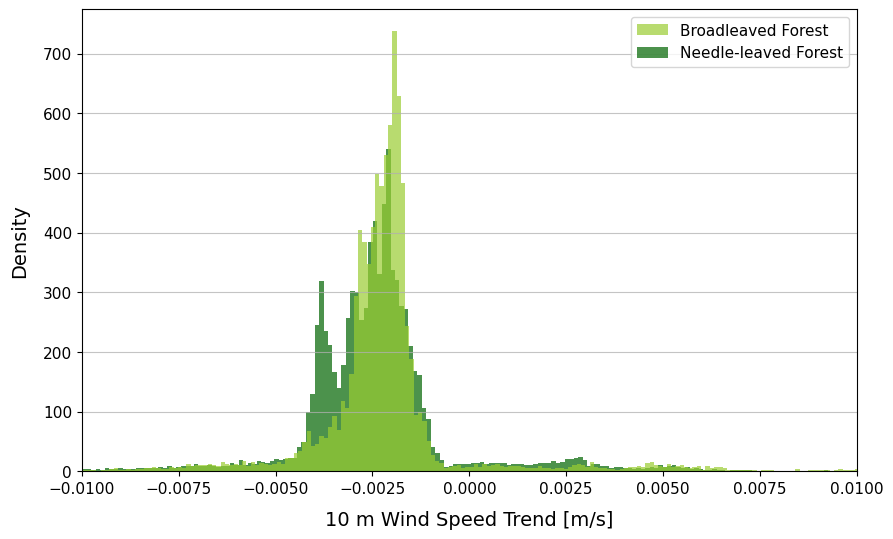

In [50]:
# plot histograms to look at distribution of values

BL_vals = wind10m_BL.variables['wind10m'][:,:].values
NL_vals = wind10m_NL.variables['wind10m'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('10 m Wind Speed Trend [m/s]', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.01, 0.01) 

plt.savefig("./Figures/Windspeed_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [51]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc}")
print(f"Calculated 75th Percentile: {vmax_perc}")

Calculated 25th Percentile: -0.003086735338623746
Calculated 75th Percentile: -0.0017931449404898824


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\2411241391.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


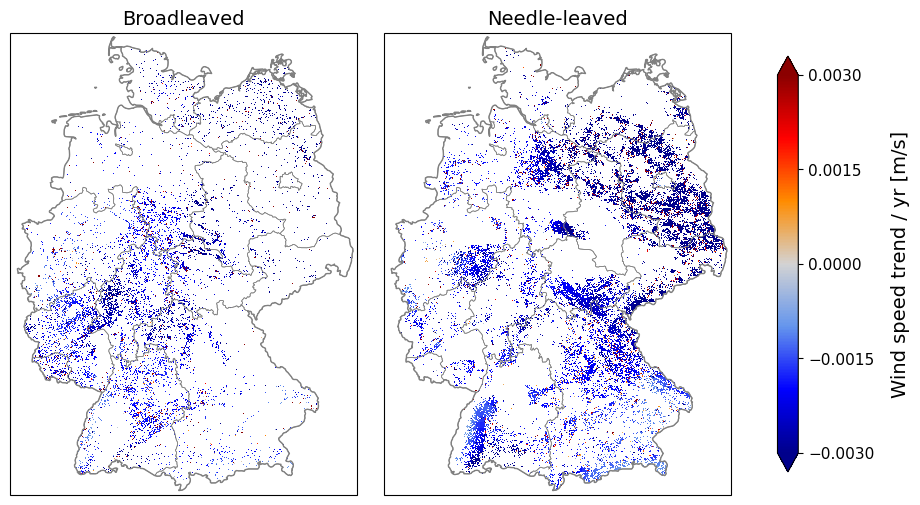

In [13]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = wind10m_BL.variables['wind10m'][:,:]
NL = wind10m_NL.variables['wind10m'][:,:]
lats = wind10m_BL.variables['lat'][:]
lons = wind10m_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.003
vmax = 0.003

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Wind speed trend / yr [m/s]", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Windspeed_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### Soil Moisture Layer 1 Trend

In [14]:
swvl1_BL = xr.open_dataset("./Spatial_Trends/swvl1_Spatial_Trend_BL.nc")
swvl1_NL = xr.open_dataset("./Spatial_Trends/swvl1_Spatial_Trend_NL.nc")

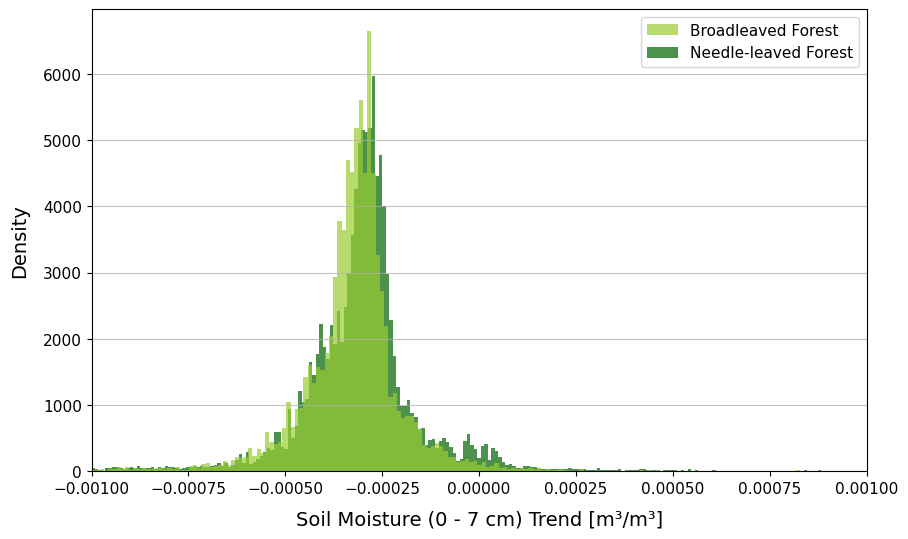

In [58]:
# plot histograms to look at distribution of values

BL_vals = swvl1_BL.variables['swvl1'][:,:].values
NL_vals = swvl1_NL.variables['swvl1'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('Soil Moisture (0 - 7 cm) Trend [m³/m³]', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.001, 0.001) 

plt.savefig("./Figures/Soil_Water_1_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [55]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc}")
print(f"Calculated 75th Percentile: {vmax_perc}")

Calculated 25th Percentile: -0.00037185661678502133
Calculated 75th Percentile: -0.0002527746392270869


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\1625980646.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


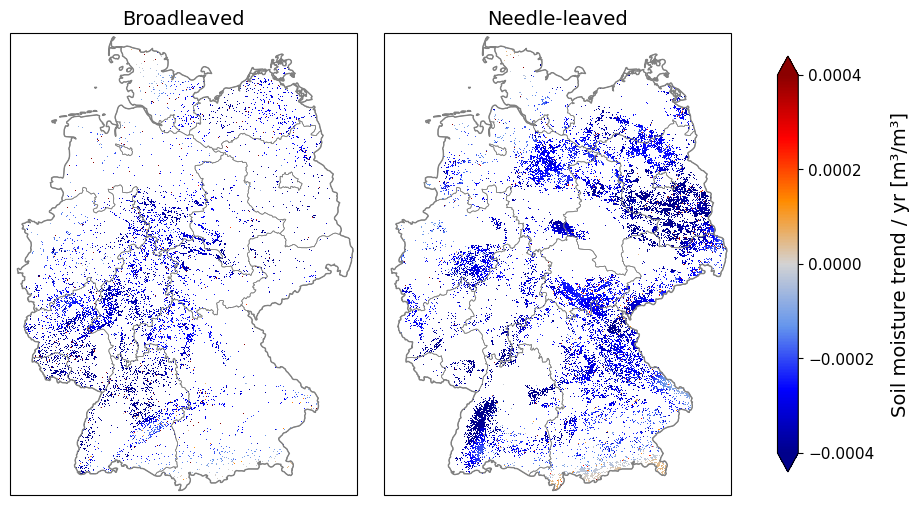

In [33]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = swvl1_BL.variables['swvl1'][:,:]
NL = swvl1_NL.variables['swvl1'][:,:]
lats = swvl1_BL.variables['lat'][:]
lons = swvl1_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0004
vmax = 0.0004

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Soil moisture trend / yr [m³/m³]", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Soil_Water_1_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### Soil Moisture Layer 2 Trend

In [35]:
swvl2_BL = xr.open_dataset("./Spatial_Trends/swvl2_Spatial_Trend_BL.nc")
swvl2_NL = xr.open_dataset("./Spatial_Trends/swvl2_Spatial_Trend_NL.nc")

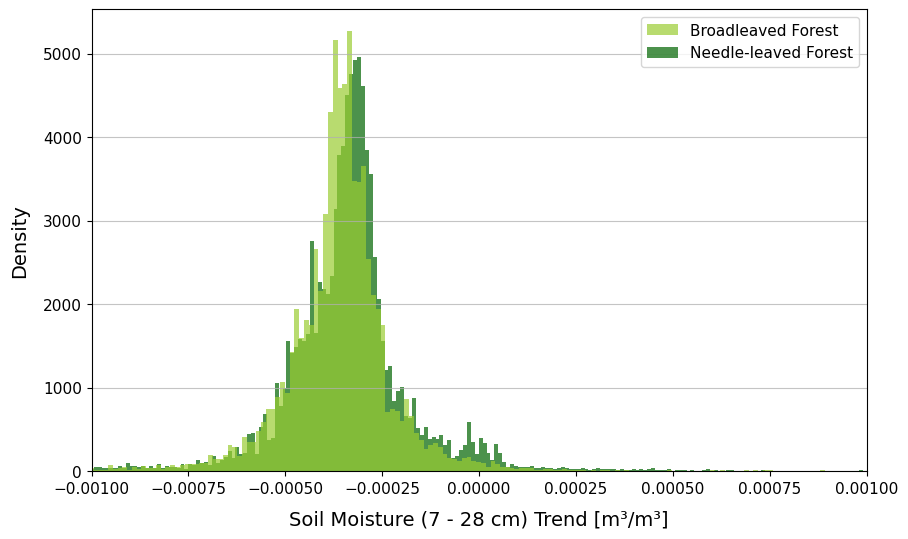

In [60]:
# plot histograms to look at distribution of values

BL_vals = swvl2_BL.variables['swvl2'][:,:].values
NL_vals = swvl2_NL.variables['swvl2'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('Soil Moisture (7 - 28 cm) Trend [m³/m³]', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10)

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.001, 0.001) 

plt.savefig("./Figures/Soil_Water_2_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [61]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc}")
print(f"Calculated 75th Percentile: {vmax_perc}")

Calculated 25th Percentile: -0.00041929768415468885
Calculated 75th Percentile: -0.000282291009486603


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\4020824090.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


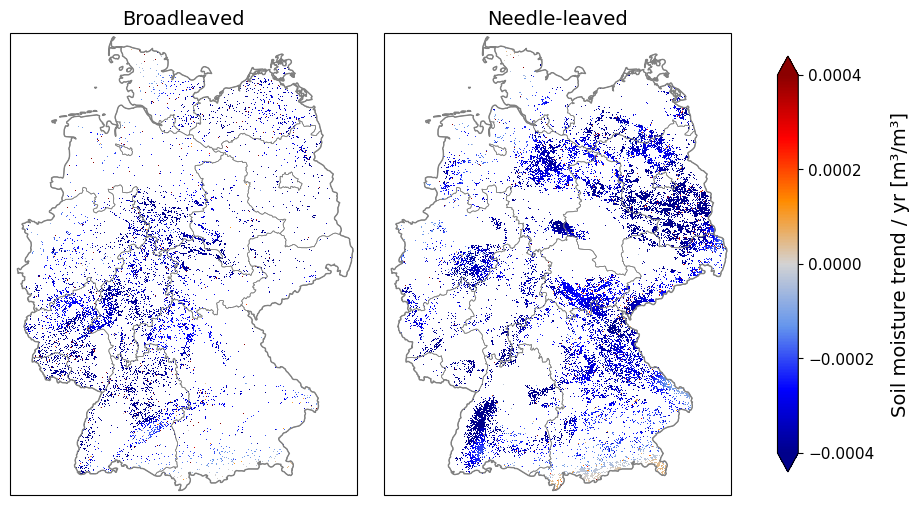

In [36]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = swvl2_BL.variables['swvl2'][:,:]
NL = swvl2_NL.variables['swvl2'][:,:]
lats = swvl2_BL.variables['lat'][:]
lons = swvl2_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0004
vmax = 0.0004

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Soil moisture trend / yr [m³/m³]", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Soil_Water_2_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### Soil Moisture Layer 3 Trend

In [37]:
swvl3_BL = xr.open_dataset("./Spatial_Trends/swvl3_Spatial_Trend_BL.nc")
swvl3_NL = xr.open_dataset("./Spatial_Trends/swvl3_Spatial_Trend_NL.nc")

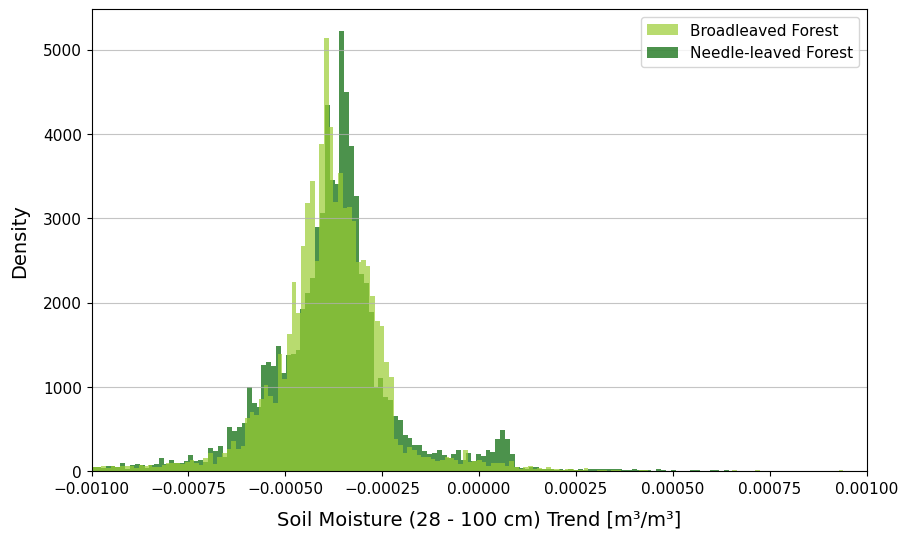

In [81]:
# plot histograms to look at distribution of values

BL_vals = swvl3_BL.variables['swvl3'][:,:].values
NL_vals = swvl3_NL.variables['swvl3'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('Soil Moisture (28 - 100 cm) Trend [m³/m³]', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.001, 0.001) 

plt.savefig("./Figures/Soil_Water_3_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [77]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc}")
print(f"Calculated 75th Percentile: {vmax_perc}")

Calculated 25th Percentile: -0.0004605422417322845
Calculated 75th Percentile: -0.0003117833982226346


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\2371487490.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


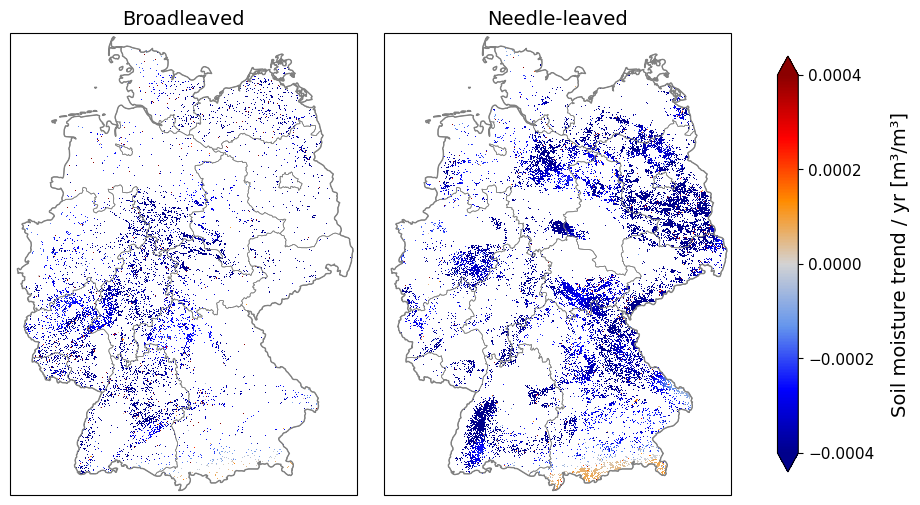

In [38]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = swvl3_BL.variables['swvl3'][:,:]
NL = swvl3_NL.variables['swvl3'][:,:]
lats = swvl3_BL.variables['lat'][:]
lons = swvl3_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0004
vmax = 0.0004

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Soil moisture trend / yr [m³/m³]", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Soil_Water_3_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### Soil Moisture Layer 4 Trend

In [39]:
swvl4_BL = xr.open_dataset("./Spatial_Trends/swvl4_Spatial_Trend_BL.nc")
swvl4_NL = xr.open_dataset("./Spatial_Trends/swvl4_Spatial_Trend_NL.nc")

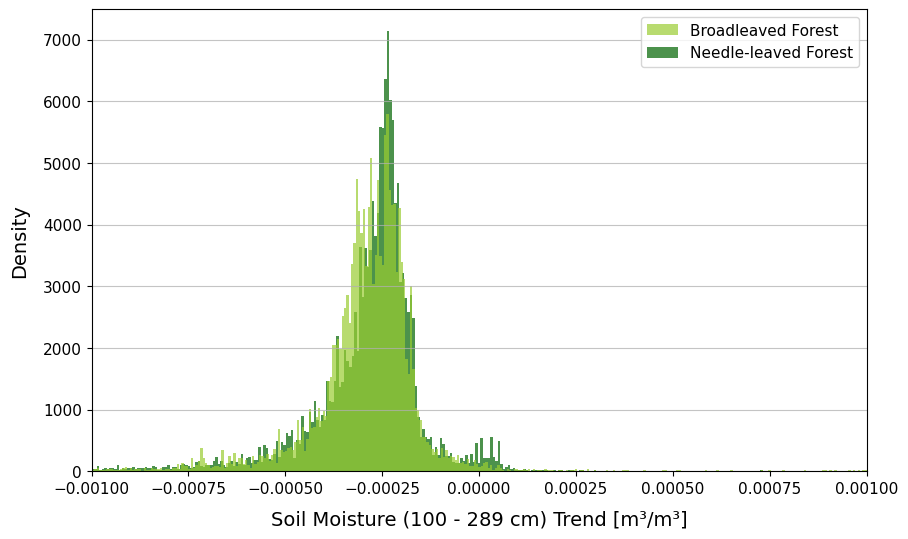

In [83]:
# plot histograms to look at distribution of values

BL_vals = swvl4_BL.variables['swvl4'][:,:].values
NL_vals = swvl4_NL.variables['swvl4'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('Soil Moisture (100 - 289 cm) Trend [m³/m³]', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.001, 0.001) 

plt.savefig("./Figures/Soil_Water_4_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [84]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc:.{10}f}")
print(f"Calculated 75th Percentile: {vmax_perc:.{10}f}")

Calculated 25th Percentile: -0.0003398560
Calculated 75th Percentile: -0.0002167679


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\3887390755.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


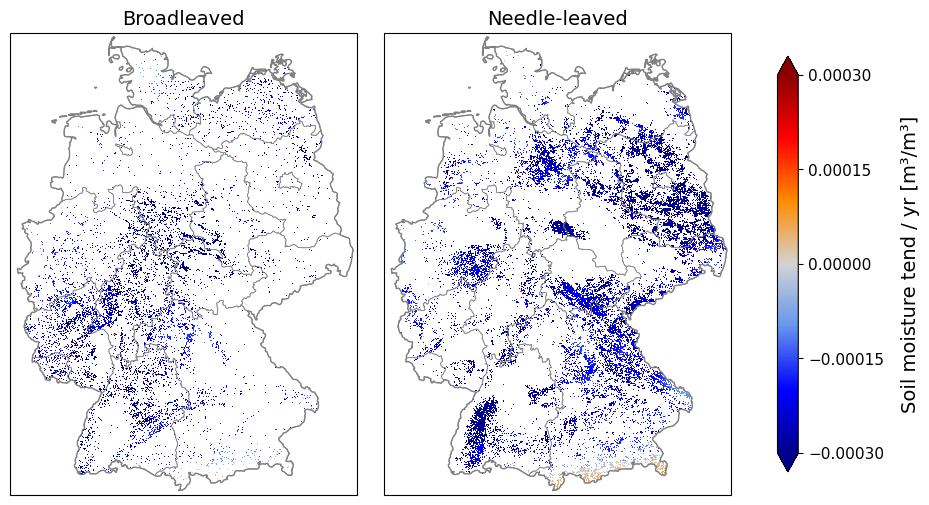

In [40]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = swvl4_BL.variables['swvl4'][:,:]
NL = swvl4_NL.variables['swvl4'][:,:]
lats = swvl4_BL.variables['lat'][:]
lons = swvl4_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0003
vmax = 0.0003

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("Soil moisture tend / yr [m³/m³]", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/Soil_Water_4_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### SPEI Trend Germany

In [18]:
spei = xr.open_dataset("./Spatial_Trends/SPEI_Spatial_Trend_GER.nc")

In [87]:
spei_vals = spei.variables['SPEI'][:,:].values

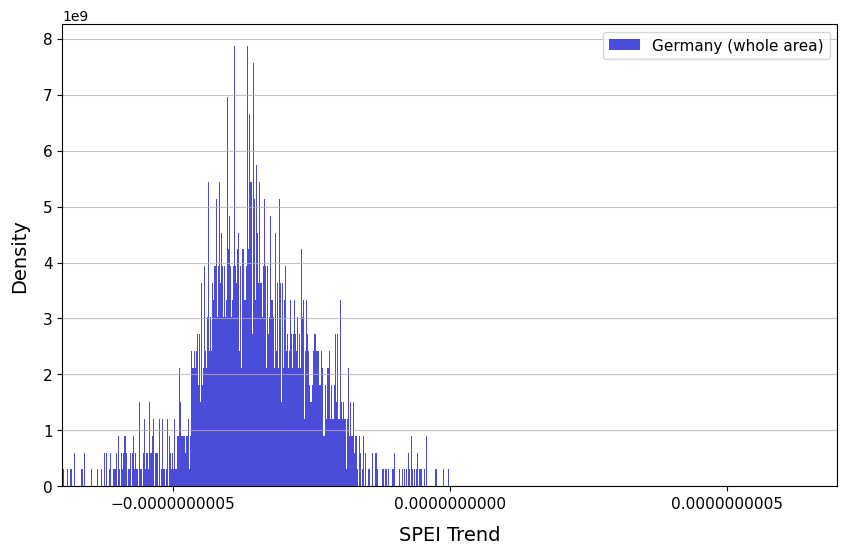

In [88]:
# plot histogram to look at distribution of values
plt.figure(figsize=(10, 6))

plt.hist(spei_vals.flatten(), bins=1000, alpha=0.7, label='Germany (whole area)', color='mediumblue', density=True) 

# add labels
plt.xlabel('SPEI Trend', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

plt.legend(loc = 1, fontsize = 11)
plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.0000000007, 0.0000000007) 

# get current axes
ax = plt.gca()

# set the x-axis to not showing scientific numbers
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.10f}'))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))

plt.savefig("./Figures/SPEI_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [89]:
# have a look at the percentiles
data = spei_vals.flatten()

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(data[~np.isnan(data)], lower_percentile)
vmax_perc = np.percentile(data[~np.isnan(data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc:.{11}f}")
print(f"Calculated 75th Percentile: {vmax_perc:.{11}f}")

Calculated 25th Percentile: -0.00000000041
Calculated 75th Percentile: -0.00000000028


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\3460809638.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


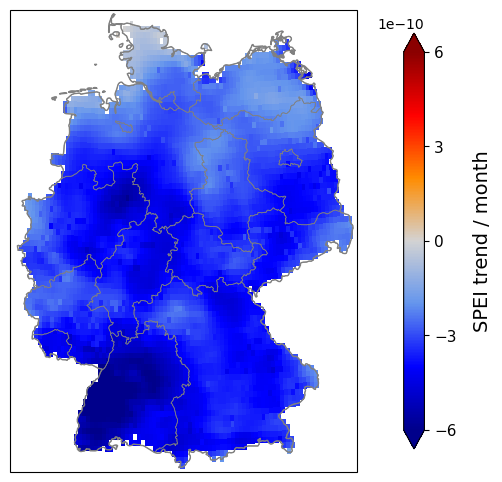

In [44]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variable from xarray
spei_var = spei.variables['SPEI'][:,:]
lats = spei.variables['lat'][:]
lons = spei.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0000000006
vmax = 0.0000000006

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# create plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})

ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

# plot data
im = ax.pcolormesh(
        lons, lats, spei_var,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto")

# plot borders
ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

# add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 
cbar.set_label("SPEI trend / month", fontsize = 14, labelpad = 12)

plt.tight_layout()
plt.savefig("./Figures/SPEI_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()

### NIRv GPP Trend

In [93]:
gpp_BL = xr.open_dataset("./Spatial_Trends/GPP_Spatial_Trend_BL.nc")
gpp_NL = xr.open_dataset("./Spatial_Trends/GPP_Spatial_Trend_NL.nc")

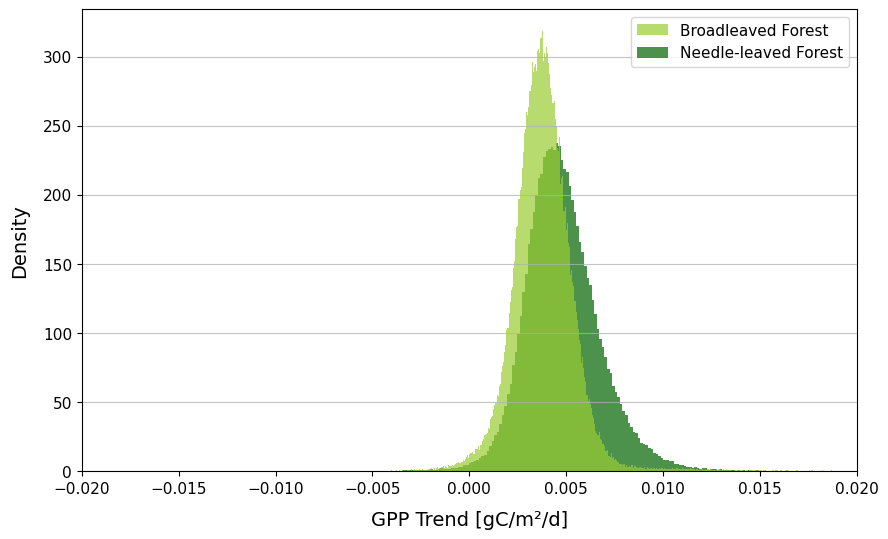

In [94]:
# plot histograms to look at distribution of values

BL_vals = gpp_BL.variables['GPP'][:,:].values
NL_vals = gpp_NL.variables['GPP'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('GPP Trend [gC/m²/d]', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.02, 0.02) 

plt.savefig("./Figures/GPP_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [95]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc:.{10}f}")
print(f"Calculated 75th Percentile: {vmax_perc:.{10}f}")

Calculated 25th Percentile: 0.0032933197
Calculated 75th Percentile: 0.0055128265


C:\Users\irish\AppData\Local\Temp\ipykernel_11460\3955606813.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


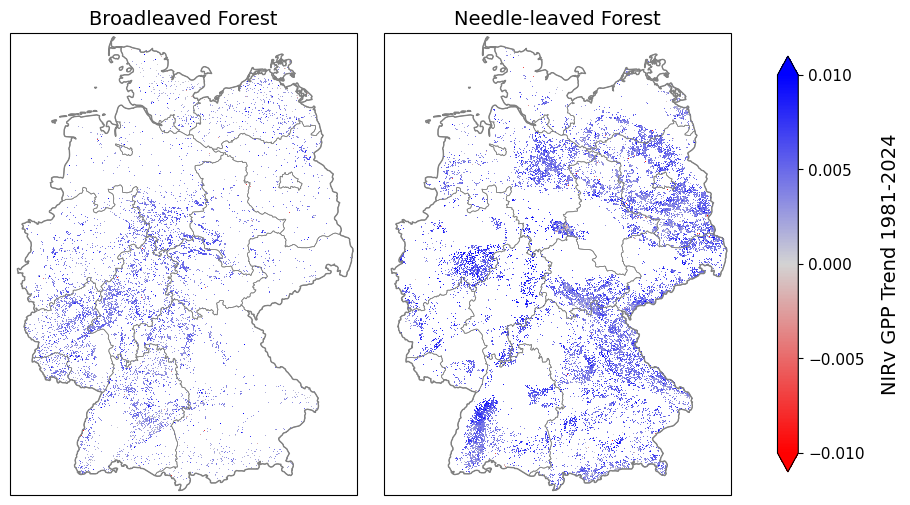

In [ ]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = gpp_BL.variables['GPP'][:,:]
NL = gpp_NL.variables['GPP'][:,:]
lats = gpp_BL.variables['lat'][:]
lons = gpp_BL.variables['lon'][:]

# create custom colormap
colors = ["blue", "lightgrey", "red"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0055
vmax = 0.0055

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("[gC/m²/d] per month", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/GPP_Spatial_Trend.png", bbox_inches="tight")
plt.show()

### NPP Trend

In [20]:
npp_BL = xr.open_dataset("./Spatial_Trends/NPP_Spatial_Trend_BL.nc")
npp_NL = xr.open_dataset("./Spatial_Trends/NPP_Spatial_Trend_NL.nc")

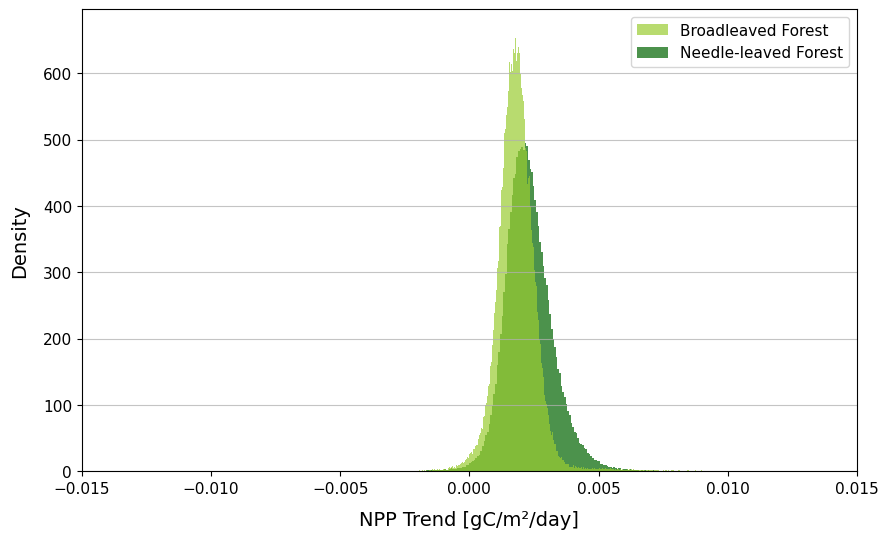

In [97]:
# plot histograms to look at distribution of values

BL_vals = npp_BL.variables['NPP'][:,:].values
NL_vals = npp_NL.variables['NPP'][:,:].values

plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.hist(NL_vals.flatten(), bins=10000, alpha=0.7, label='Needle-leaved Forest', color='darkgreen', density=True) 
ax.hist(BL_vals.flatten(), bins=10000, alpha=0.7, label='Broadleaved Forest', color='yellowgreen', density=True)

# add labels
plt.xlabel('NPP Trend [gC/m²/day]', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10) 

# get labels and handles
handles, labels = ax.get_legend_handles_labels()

# define order of elements in legend
order = ['Broadleaved Forest', 'Needle-leaved Forest']
reordered_handles = [handles[labels.index(l)] for l in order]
reordered_labels = [l for l in order]

# add legend
plt.legend(reordered_handles, reordered_labels, loc=1, fontsize = 11)

plt.grid(axis='y', alpha=0.75) 
plt.tick_params(axis='both', which='major', labelsize=11)

plt.xlim(-0.015, 0.015) 

plt.savefig("./Figures/NPP_Spatial_Trend_Histogram.png", bbox_inches="tight", dpi = 300)
plt.show()

In [98]:
# have a look at the percentiles
# for both data combined
all_data = np.concatenate((BL_vals.flatten(), NL_vals.flatten()))

lower_percentile = 25
upper_percentile = 75

vmin_perc = np.percentile(all_data[~np.isnan(all_data)], lower_percentile)
vmax_perc = np.percentile(all_data[~np.isnan(all_data)], upper_percentile)

print(f"Calculated 25th Percentile: {vmin_perc:.{10}f}")
print(f"Calculated 75th Percentile: {vmax_perc:.{10}f}")

Calculated 25th Percentile: 0.0015807935
Calculated 75th Percentile: 0.0026461567


C:\Users\irish\AppData\Local\Temp\ipykernel_22140\3166247934.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


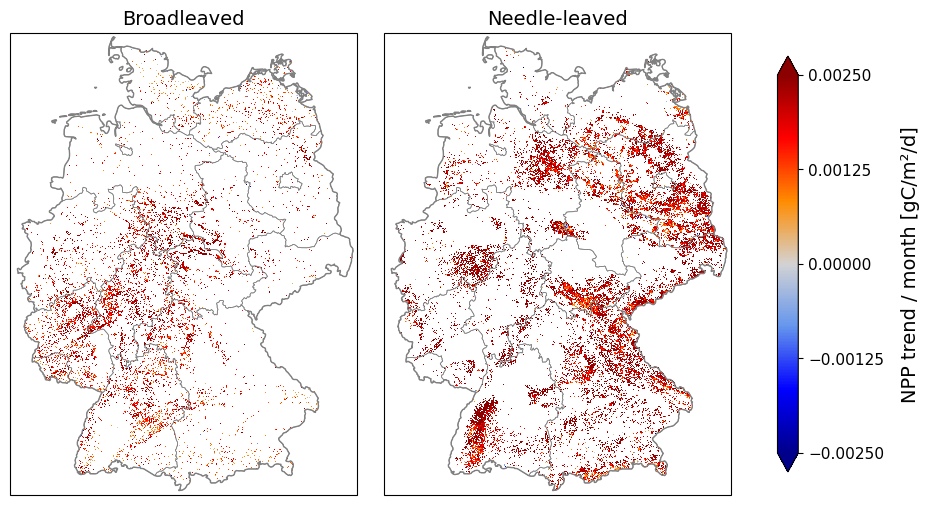

In [45]:
# set native crs and desired projection for map
projPC = ccrs.PlateCarree()
projUTM = ccrs.UTM(zone=32)

# get variables from xarrays
BL = npp_BL.variables['NPP'][:,:]
NL = npp_NL.variables['NPP'][:,:]
lats = npp_BL.variables['lat'][:]
lons = npp_BL.variables['lon'][:]

# create custom colormap
colors = ["darkblue", "blue", "cornflowerblue", "lightgrey", "darkorange", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors, N=256)

# set nan values as transparent
cmap.set_bad(alpha = 0)

# set boundary values for colormap to show small differences in values
# values beyond these boundaries will be shown by the "extend" option
vmin = -0.0025
vmax = 0.0025

# normalize data, set grey at 0.0000 with TwoSlopeNorm
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projUTM}, gridspec_kw={"wspace": 0.01})
for ax, data, title in zip(axes, [BL, NL], ['Broadleaved', 'Needle-leaved']):
    # set extent
    ax.set_extent([5.9, 14.65, 47.2, 55], crs=projPC)

    # plot data
    im = ax.pcolormesh(
        lons, lats, data,
        cmap=cmap,
        norm=norm,
        transform=projPC,
        shading = "auto"
    )

    # plot borders
    ger_states.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 0.5, transform=projUTM)
    ger_border.boundary.plot(ax=ax, edgecolor = "grey", linewidth = 1, transform=projUTM)

    ax.set_title(f"{title}", fontsize = 14)

# add colorbar
cbar = plt.colorbar(im, ax=axes, orientation='vertical', shrink=0.9, pad=0.05, extend = "both")
cbar.set_label("NPP trend / month [gC/m²/d]", fontsize = 14, labelpad = 12)
cbar.set_ticks(np.linspace(vmin, vmax, 5))
cbar.ax.tick_params(labelsize=11) 

plt.tight_layout()
plt.savefig("./Figures/NPP_Spatial_Trend.png", bbox_inches="tight", dpi = 300)
plt.show()